In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from tabpfn_extensions import TabPFNRegressor,interpretability

# Import tabpfn adapters from interpretability module
#from tabpfn_extensions.interpretability import shapiq as tabpfn_shapiq


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/纯苯-Brent价差拟合残差-亚洲PX负荷.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接,山东92#汽油净价-布伦特超季节性/3年,甲苯歧化加工费/到PX/美国,南华工业品指数60日环比,Brent原油期货连1合约价格/路透同比,美湾单位辛烷值价格超季节性/3年,纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年,金银比超季节性/3年,Brent原油期货连1合约价格/路透,RBOB汽油裂解价差（均价）,苯乙烯非一体化周度开工（外采纯苯型）同差,纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新,纯苯下游综合利润超季节性/3年
2025-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,6.5272,NaN
2025-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['布伦特原油期货价格'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,Brent原油期货价格预测
20,2025-10-29,76.13
19,2025-10-30,77.47
18,2025-10-31,78.52
17,2025-11-03,79.34
16,2025-11-04,80.35


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', 'Brent原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货连1合约价格/路透'] = sheet_daily['Brent原油期货连1合约价格/路透'].fillna(sheet_daily['Brent原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['Brent原油期货价格预测'])

# 计算Brent原油期货连1合约价格/路透同比
# 参考go语言的时间匹配原理:
# 1. 对于每个日期,找到去年完全相同的日期(月和日相同)
# 2. 如果去年同一天没有数据,则向前找最近的交易日

# 只处理last_day之后的数据
forecast_period = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 创建一个函数来找到去年同期的值
def get_previous_year_value(current_date, df):
    # 获取去年同一天的日期
    previous_year_date = current_date - pd.DateOffset(years=1)
    
    # 在历史数据中查找最接近的交易日
    historical_data = df[df['Date'] <= previous_year_date]
    if len(historical_data) == 0:
        return None
    
    # 找到最接近的交易日的数据
    closest_date = historical_data['Date'].iloc[
        (historical_data['Date'] - previous_year_date).abs().argsort()[0]
    ]
    return df[df['Date'] == closest_date]['Brent原油期货连1合约价格/路透'].iloc[0]

# 计算同比
historical_prices = forecast_period['Date'].apply(
    lambda x: get_previous_year_value(x, sheet_daily)
)

# 计算同比变化率
forecast_period['Brent原油期货连1合约价格/路透同比'] = (
    (forecast_period['Brent原油期货连1合约价格/路透'] - historical_prices) / 
    historical_prices
)

# 更新原始数据框
sheet_daily['Brent原油期货连1合约价格/路透同比'] = sheet_daily['Brent原油期货连1合约价格/路透同比'].fillna(forecast_period['Brent原油期货连1合约价格/路透同比'])



# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [7]:
sheet.columns

Index(['纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接',
       '山东92#汽油净价-布伦特超季节性/3年', '甲苯歧化加工费/到PX/美国', '南华工业品指数60日环比',
       'Brent原油期货连1合约价格/路透同比', '美湾单位辛烷值价格超季节性/3年',
       '纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年', '金银比超季节性/3年', 'Brent原油期货连1合约价格/路透',
       'RBOB汽油裂解价差（均价）', '苯乙烯非一体化周度开工（外采纯苯型）同差',
       '纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新', '纯苯下游综合利润超季节性/3年'],
      dtype='object')

In [8]:
################################# 处理缺失值 #################################
fill_methods = {
      '山东92#汽油净价-布伦特超季节性/3年': 'interpolate',
      '甲苯歧化加工费/到PX/美国': 'interpolate',
      '南华工业品指数60日环比': 'interpolate', 
      'Brent原油期货连1合约价格/路透同比': 'interpolate',
      '美湾单位辛烷值价格超季节性/3年': 'interpolate',
      '纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年': 'interpolate',
      '金银比超季节性/3年': 'interpolate',
      'RBOB汽油裂解价差（均价）': 'interpolate',
      '苯乙烯非一体化周度开工（外采纯苯型）同差': 'interpolate',
      '纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新': 'interpolate',
      '纯苯下游综合利润超季节性/3年':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################
sheet['山东92#汽油净价-布伦特超季节性/3年_提前30天'] = sheet['山东92#汽油净价-布伦特超季节性/3年'].shift(30)
sheet['甲苯歧化加工费/到PX/美国_提前15天'] = sheet['甲苯歧化加工费/到PX/美国'].shift(15)
sheet['南华工业品指数60日环比_提前40天'] = sheet['南华工业品指数60日环比'].shift(40)
sheet['Brent原油期货连1合约价格/路透同比_提前10天'] = sheet['Brent原油期货连1合约价格/路透同比'].shift(10)
sheet['美湾单位辛烷值价格超季节性/3年_提前20天'] = sheet['美湾单位辛烷值价格超季节性/3年'].shift(20)
sheet['纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年_提前50天'] = sheet['纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年'].shift(50)
sheet['金银比超季节性/3年_提前70天'] = sheet['金银比超季节性/3年'].shift(70)
sheet['RBOB汽油裂解价差（均价）_提前30天'] = sheet['RBOB汽油裂解价差（均价）'].shift(30)
sheet['纯苯下游综合利润超季节性/3年_提前20天'] = sheet['纯苯下游综合利润超季节性/3年'].shift(20)

sheet['金银比超季节性/3年_提前70天_逆序'] = reverse_column(sheet, '金银比超季节性/3年_提前70天')
sheet['纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年_提前50天_逆序'] = reverse_column(sheet, '纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年_提前50天')
sheet['纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新_逆序'] = reverse_column(sheet, '纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接'].notna())
]

################################# 数据 读取-处理 结束 #################################

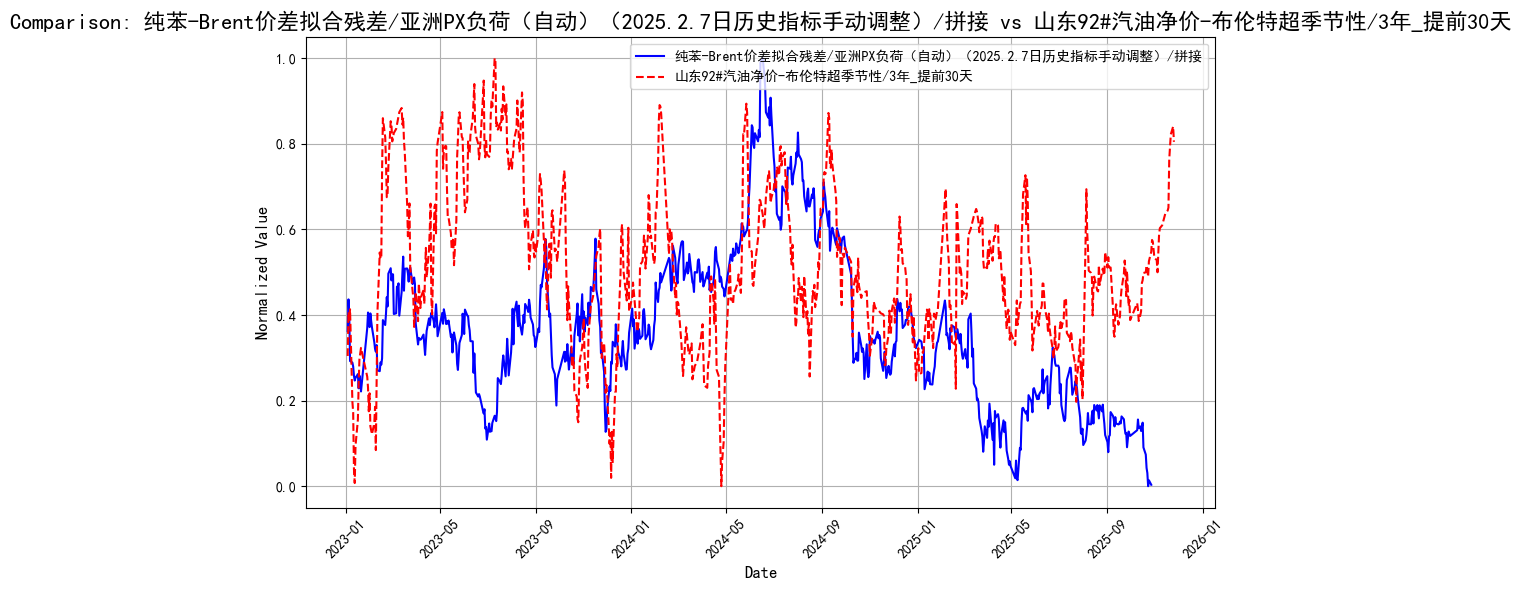

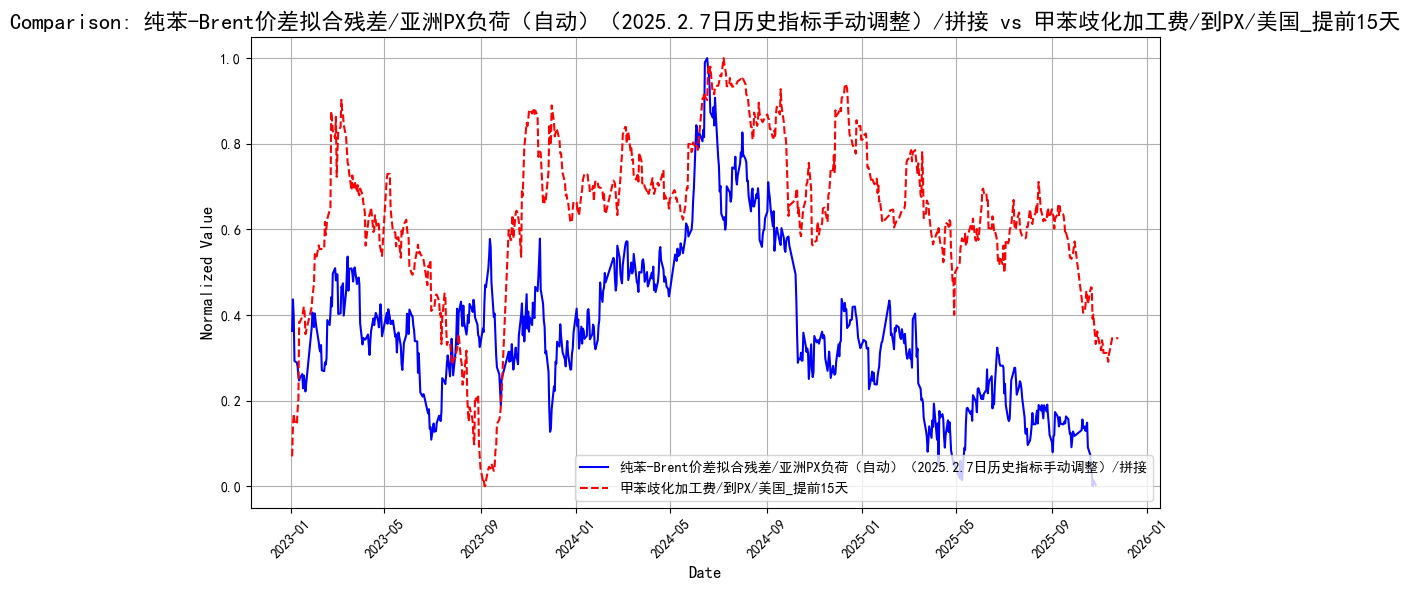

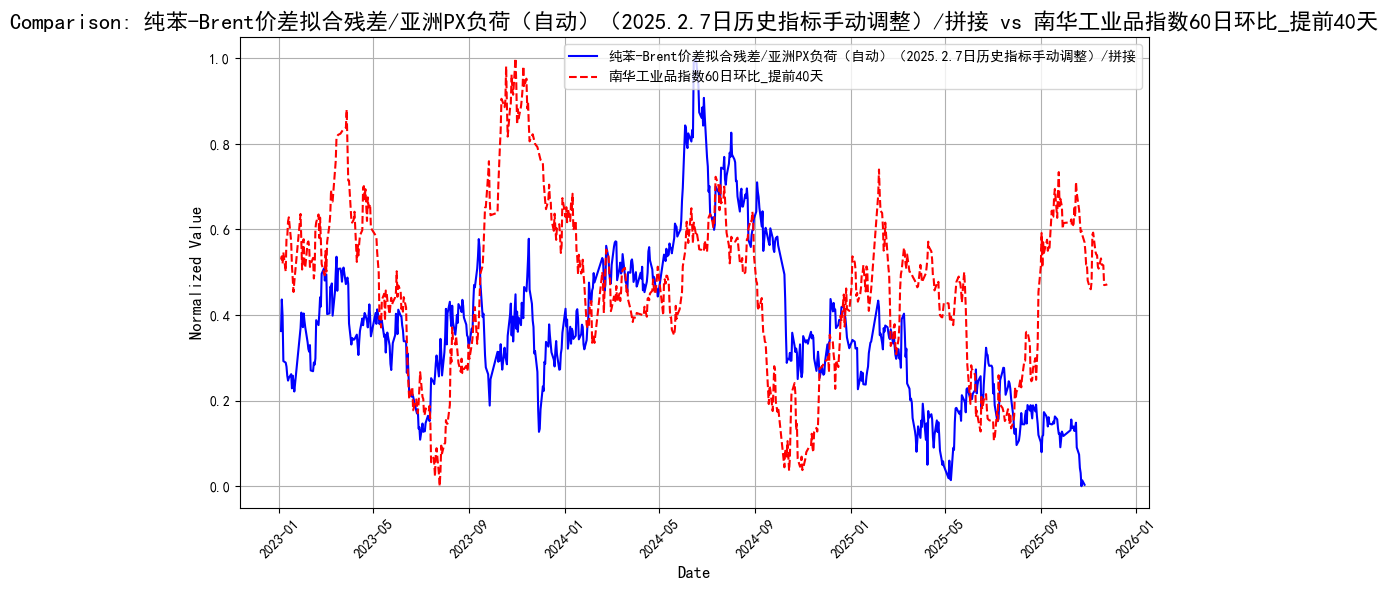

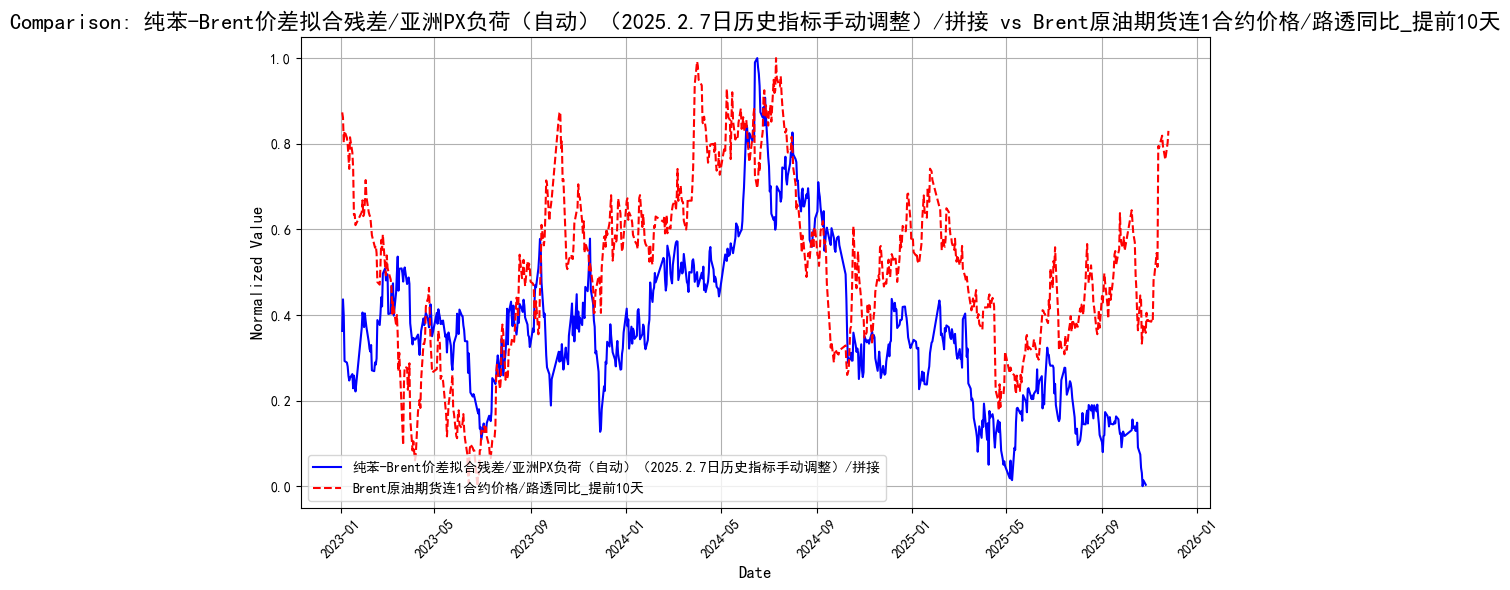

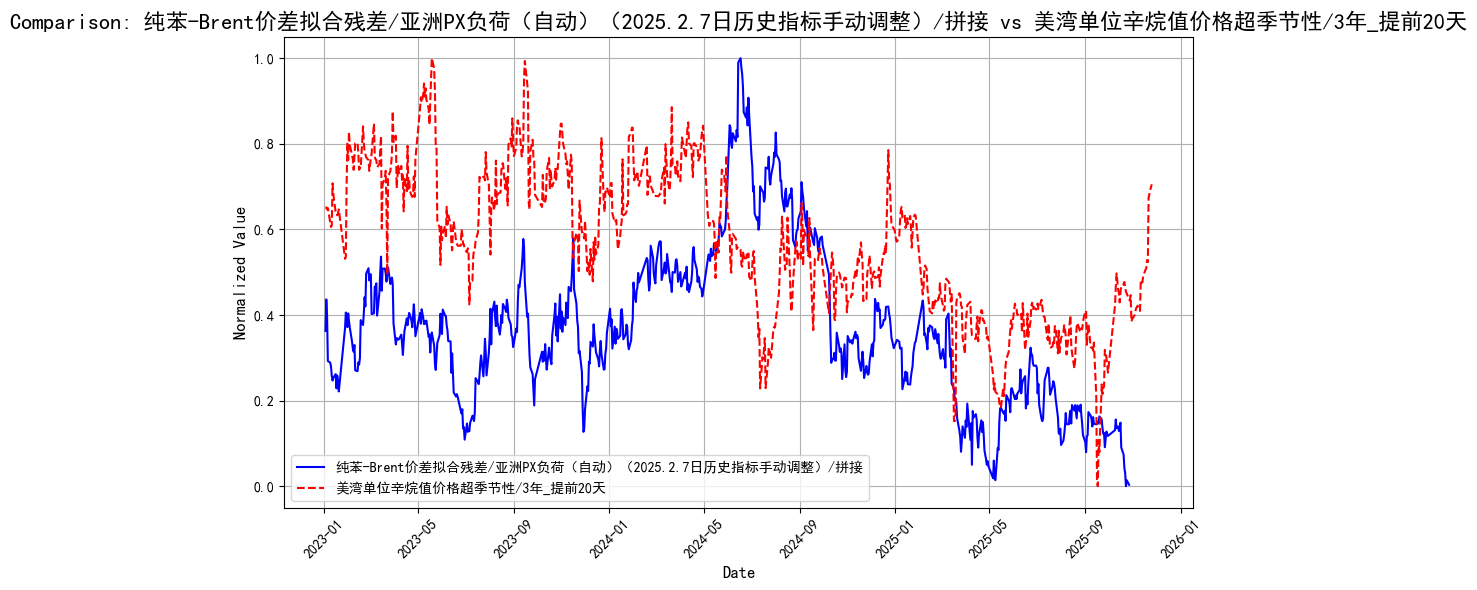

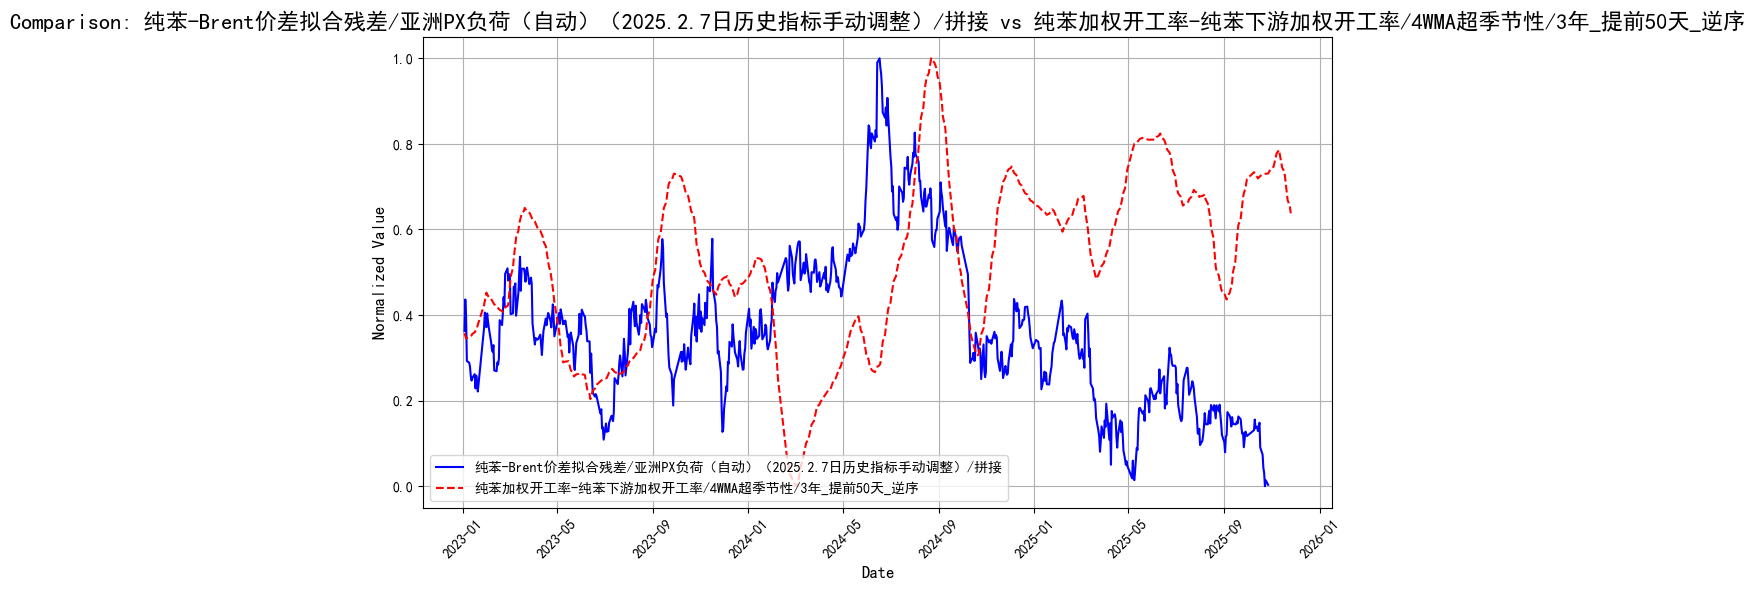

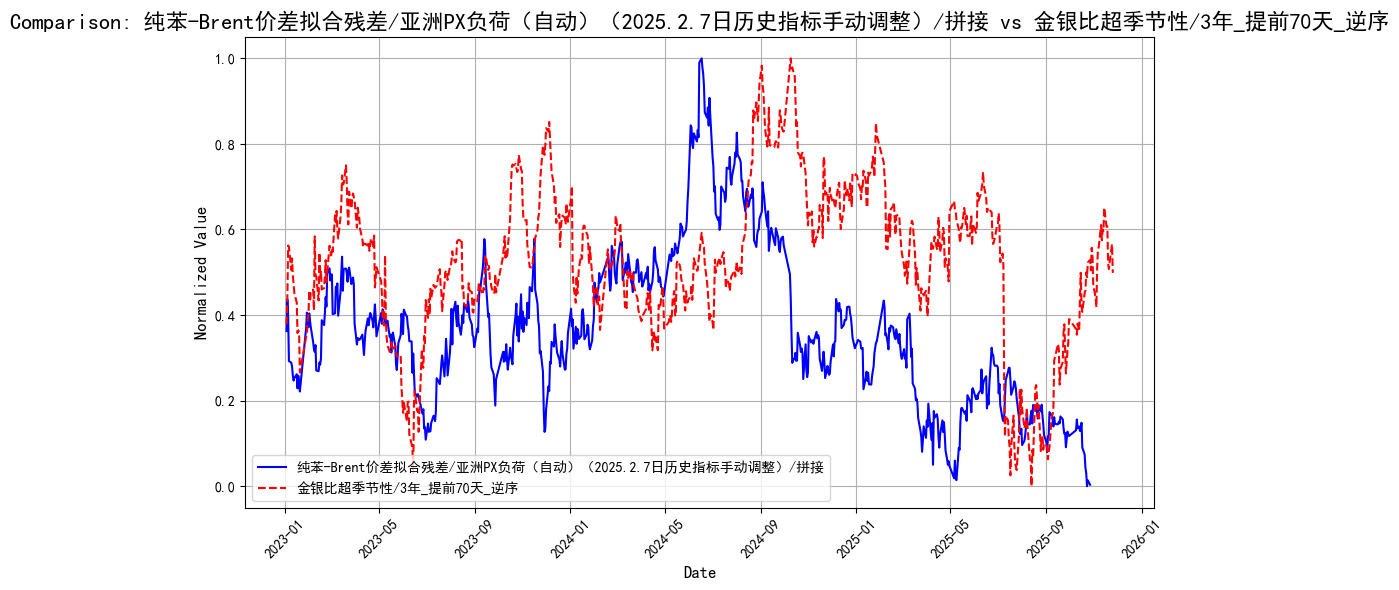

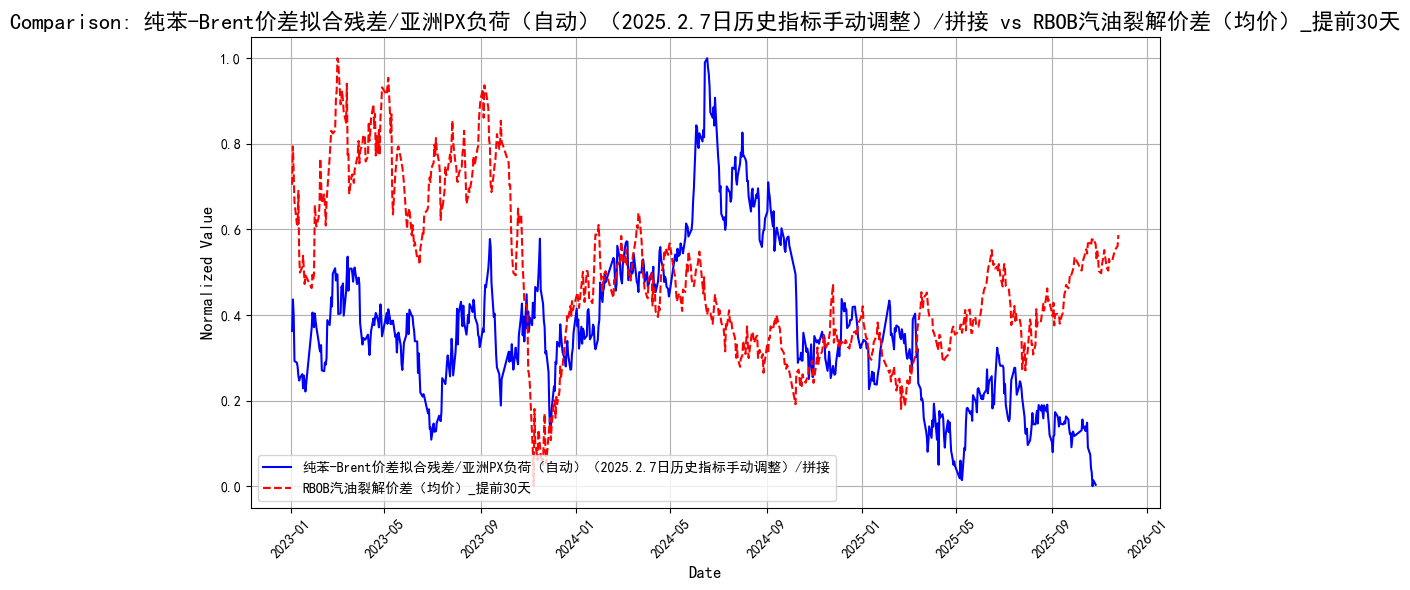

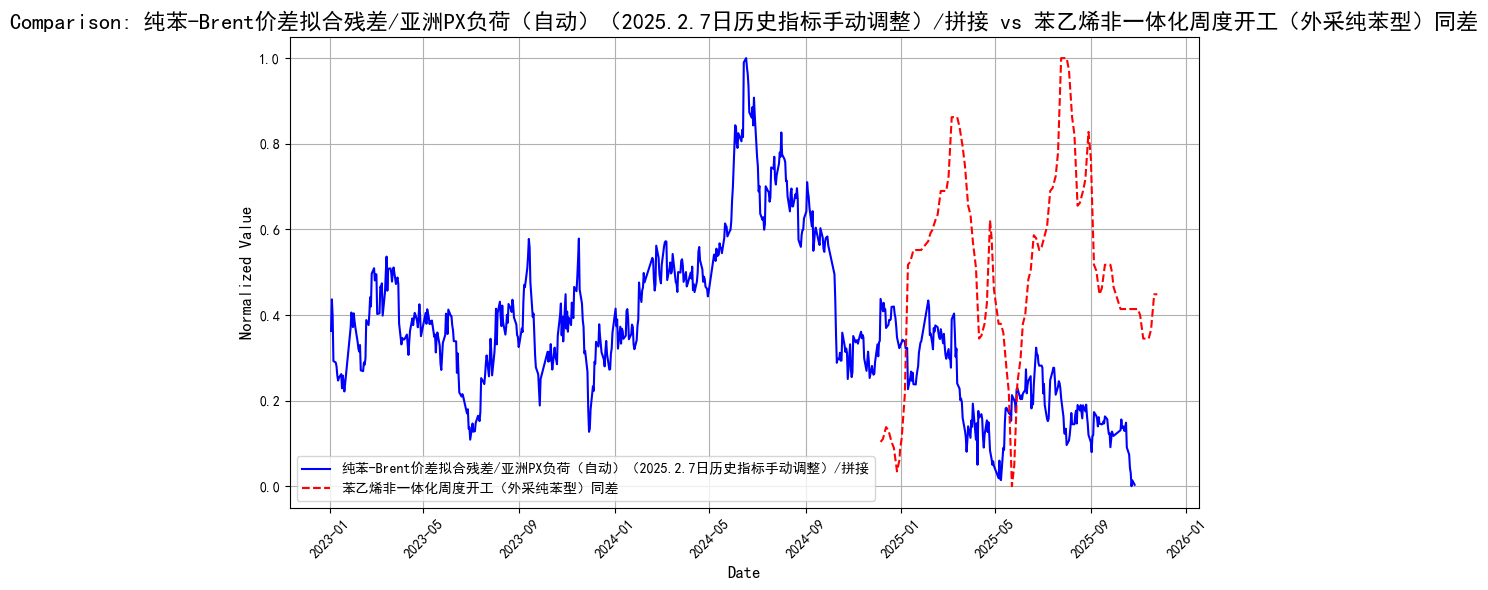

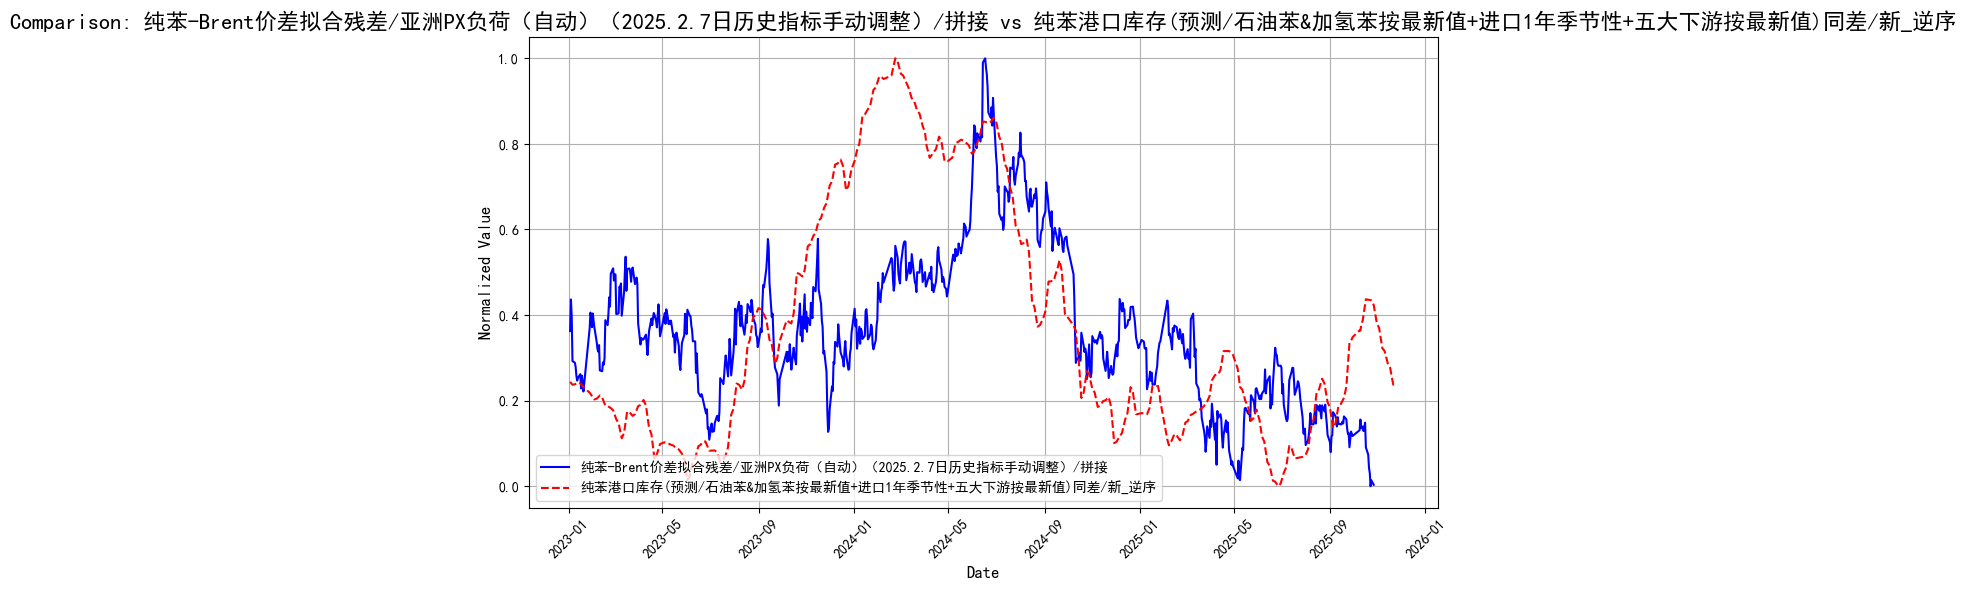

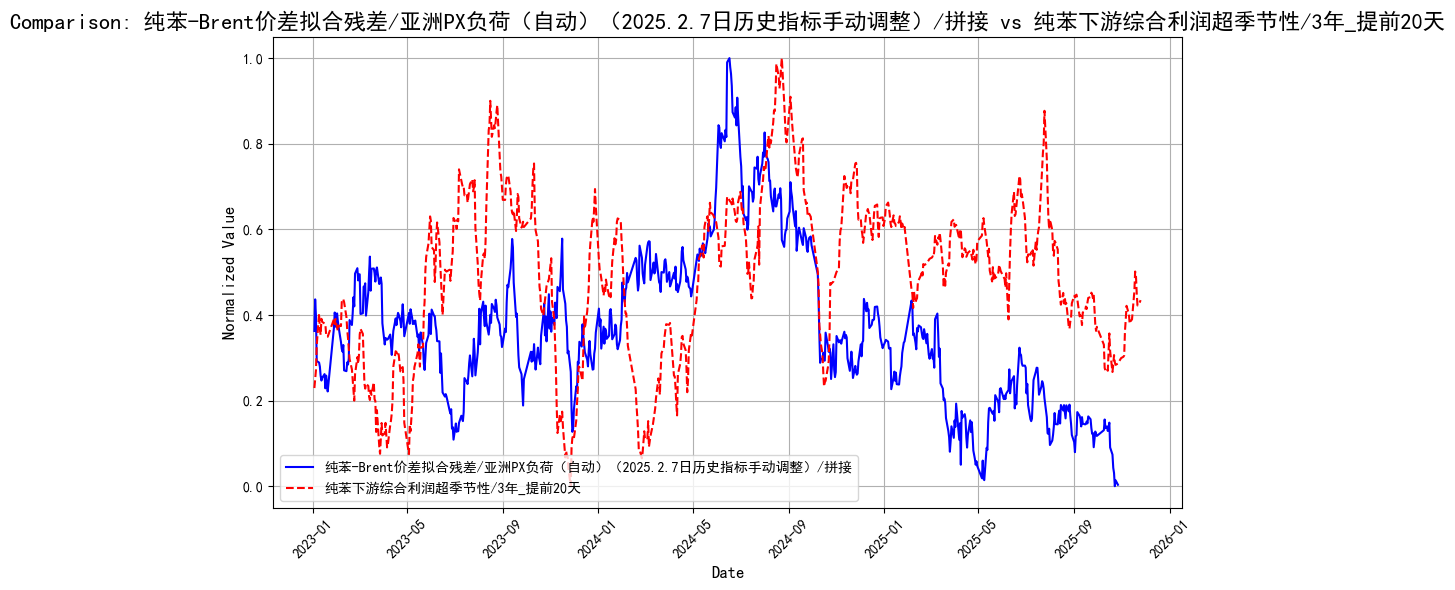

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接', 
    compare_cols=[
        '山东92#汽油净价-布伦特超季节性/3年_提前30天',
        '甲苯歧化加工费/到PX/美国_提前15天',
        '南华工业品指数60日环比_提前40天',
        'Brent原油期货连1合约价格/路透同比_提前10天',
        '美湾单位辛烷值价格超季节性/3年_提前20天',
        '纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年_提前50天_逆序',
        '金银比超季节性/3年_提前70天_逆序',
        'RBOB汽油裂解价差（均价）_提前30天',
        '苯乙烯非一体化周度开工（外采纯苯型）同差',
        '纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新_逆序',
        '纯苯下游综合利润超季节性/3年_提前20天'
        ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 50
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '山东92#汽油净价-布伦特超季节性/3年_提前30天',
    '甲苯歧化加工费/到PX/美国_提前15天',
#    '南华工业品指数60日环比_提前40天',
    'Brent原油期货连1合约价格/路透同比_提前10天',
    '美湾单位辛烷值价格超季节性/3年_提前20天',
    '纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年_提前50天_逆序',
    '金银比超季节性/3年_提前70天_逆序',
#    'RBOB汽油裂解价差（均价）_提前30天',
    '苯乙烯非一体化周度开工（外采纯苯型）同差',
    '纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新_逆序',
    '纯苯下游综合利润超季节性/3年_提前20天'
]

predict_column = '纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]


In [11]:
################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 85)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 默认学习率
    'max_depth': 12,  # 默认树深度
    'min_child_weight': 8,  # 默认最小子节点权重
    'subsample': 0.8,  # 默认子采样比例
    'colsample_bytree': 0.8,  # 默认特征采样比例
    'gamma': 1,  # 默认最小分裂损失
    'reg_alpha': 0.5,  # 默认L1正则化
    'reg_lambda': 1.5,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:922.33481	train-rmse:587.95774


[500]	eval-rmse:706.97950	train-rmse:65.17970


[999]	eval-rmse:690.75528	train-rmse:34.05325


训练集 MSE (DMatrix): 1417.9773, 训练集 R² (DMatrix): 0.9966
测试集 MSE (DMatrix): 477142.8573, 测试集 R² (DMatrix): -15.0898


In [12]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:609.09375


[500]	train-rmse:63.42533


[999]	train-rmse:33.87470


全部数据 MSE: 1484.5864, 全部数据 R²: 0.9967


In [13]:
'''
################################# TabPFN 模型 训练 测试 预测 #################################

# 初始化回归器
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# 在测试集和未来数据上预测
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")
print(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")

# 存储预测结果
y_future_pred = regressor.predict(X_future)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred
'''


'\n################################# TabPFN 模型 训练 测试 预测 #################################\n\n# 初始化回归器\nregressor = TabPFNRegressor()\nregressor.fit(X_train, y_train)\n\n# 在测试集和未来数据上预测\ny_train_pred = regressor.predict(X_train)\ny_test_pred = regressor.predict(X_test)\n\n\n# 评估模型\ntrain_mse = mean_squared_error(y_train, y_train_pred)\ntrain_r2 = r2_score(y_train, y_train_pred)\ntest_mse = mean_squared_error(y_test, y_test_pred)\ntest_r2 = r2_score(y_test, y_test_pred)\n\nprint(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")\nprint(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")\n\n# 存储预测结果\ny_future_pred = regressor.predict(X_future)\ntest_data.loc[:, \'预测值\'] = y_test_pred\nfuture_data.loc[:, \'预测值\'] = y_future_pred\n'

In [14]:
'''

################################# TabPFN 模型 训练 测试 预测 所有数据 #################################
# 合并所有数据
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 初始化回归器
regressor_all = TabPFNRegressor()
regressor_all.fit(X_all, y_all)

# 预测所有数据和未来数据
y_all_pred = regressor_all.predict(X_all)
y_future_pred_all = regressor_all.predict(X_future)

# 评估模型
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all
'''

'\n\n################################# TabPFN 模型 训练 测试 预测 所有数据 #################################\n# 合并所有数据\nX_all = pd.concat([X_train, X_test]).reset_index(drop=True)\ny_all = pd.concat([y_train, y_test]).reset_index(drop=True)\n\n# 初始化回归器\nregressor_all = TabPFNRegressor()\nregressor_all.fit(X_all, y_all)\n\n# 预测所有数据和未来数据\ny_all_pred = regressor_all.predict(X_all)\ny_future_pred_all = regressor_all.predict(X_future)\n\n# 评估模型\nall_mse = mean_squared_error(y_all, y_all_pred)\nall_r2 = r2_score(y_all, y_all_pred)\n\nprint(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")\n\n# 存储全部数据的预测结果\nall_data = pd.concat([train_data, test_data]).reset_index(drop=True)\nall_data.loc[:, \'预测值_全量\'] = y_all_pred\nfuture_data.loc[:, \'预测值_全量\'] = y_future_pred_all\n'

In [15]:
'''
# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=regressor_all,
    X=X_all,
    y=y_all,
    n_features_to_select=5,  # How many features to select
    feature_names=X_all.columns,
)

# Print selected features
selected_features = [
    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")
'''

'\n# Feature selection\nsfs = interpretability.feature_selection.feature_selection(\n    estimator=regressor_all,\n    X=X_all,\n    y=y_all,\n    n_features_to_select=5,  # How many features to select\n    feature_names=X_all.columns,\n)\n\n# Print selected features\nselected_features = [\n    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]\n]\nprint("\nSelected features:")\nfor feature in selected_features:\n    print(f"- {feature}")\n'

In [16]:
'''
# Get a TabPFNExplainer
n_model_evals = 500
x_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组
explainer = tabpfn_shapiq.get_tabpfn_explainer(
    model=regressor_all,
    data=X_all,
    labels=X_all, 
    index="SV",  # SV: Shapley Value (like in shap)
    verbose=True,  # show a progress bar during explanation
)

# Get shap values
print("计算SHAP值...")
shapley_values = explainer.explain(x=x_explain, budget=n_model_evals)

# plot the force plot
shapley_values.plot_force(feature_names=X_all.columns)
'''

'\n# Get a TabPFNExplainer\nn_model_evals = 500\nx_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组\nexplainer = tabpfn_shapiq.get_tabpfn_explainer(\n    model=regressor_all,\n    data=X_all,\n    labels=X_all, \n    index="SV",  # SV: Shapley Value (like in shap)\n    verbose=True,  # show a progress bar during explanation\n)\n\n# Get shap values\nprint("计算SHAP值...")\nshapley_values = explainer.explain(x=x_explain, budget=n_model_evals)\n\n# plot the force plot\nshapley_values.plot_force(feature_names=X_all.columns)\n'

In [17]:
'''
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
'''

"\nplt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')\nplt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') \nplt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)\nplt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')\nplt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')\nplt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')\n"

Gap between last actual value and first prediction: -164.99234414062494


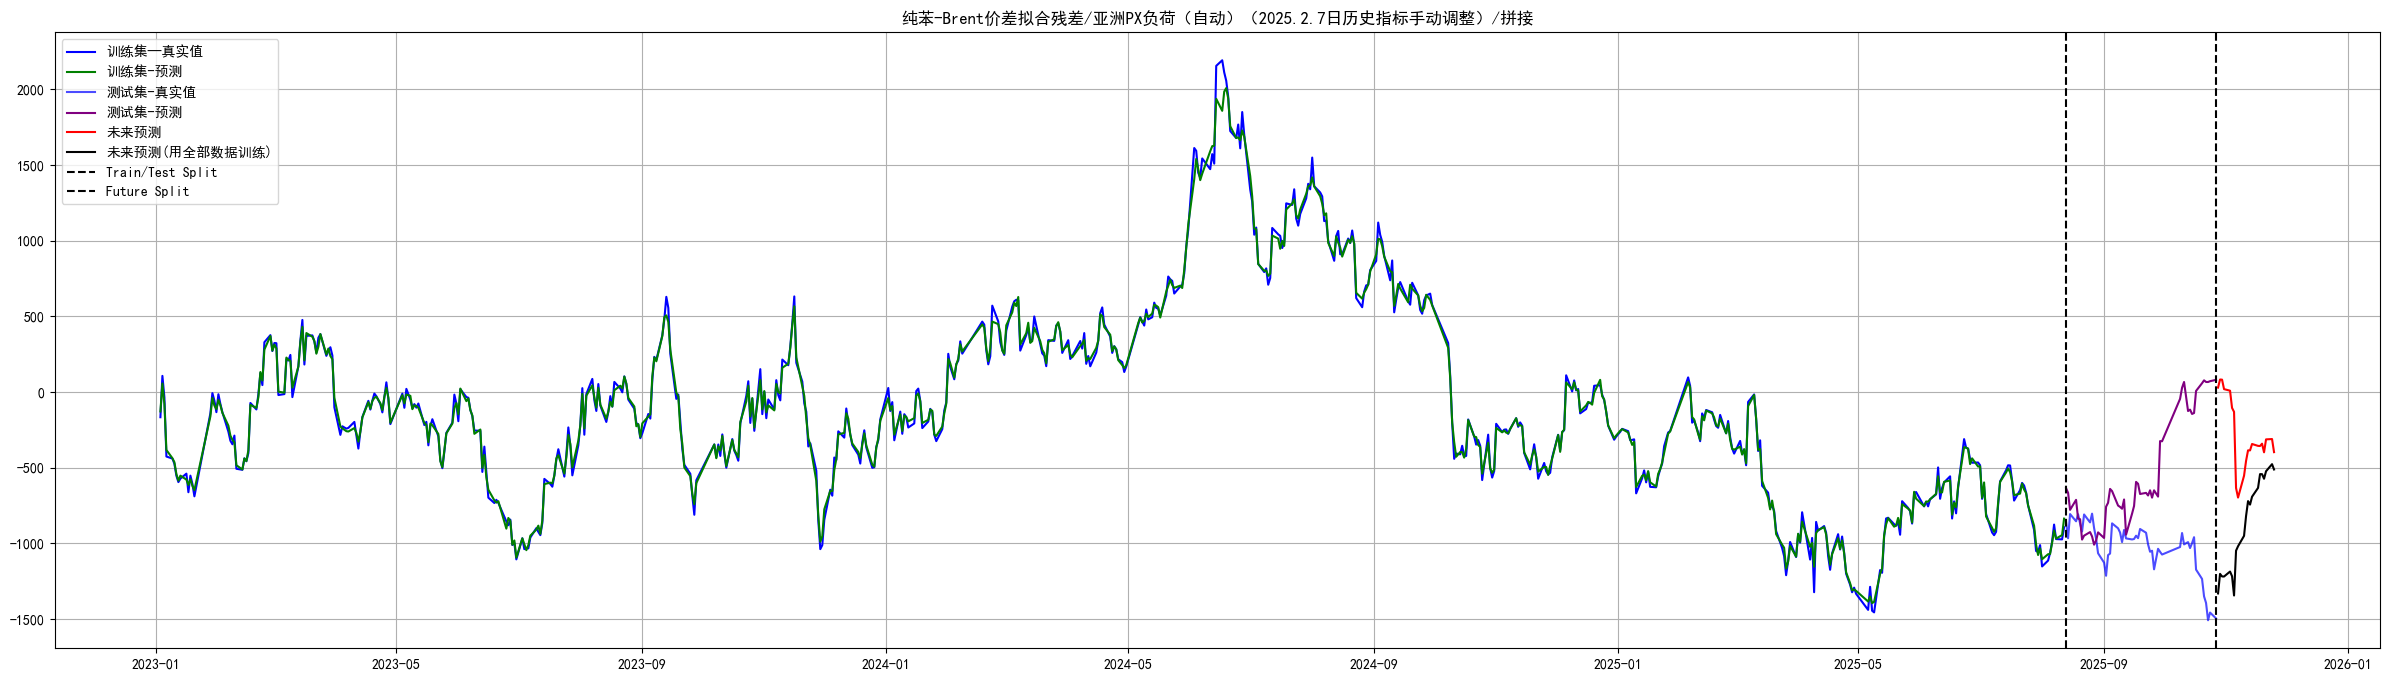

In [18]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('纯苯-Brent价差拟合残差/亚洲PX负荷（自动）（2025.2.7日历史指标手动调整）/拼接')
plt.legend()
plt.grid(True)
plt.show()

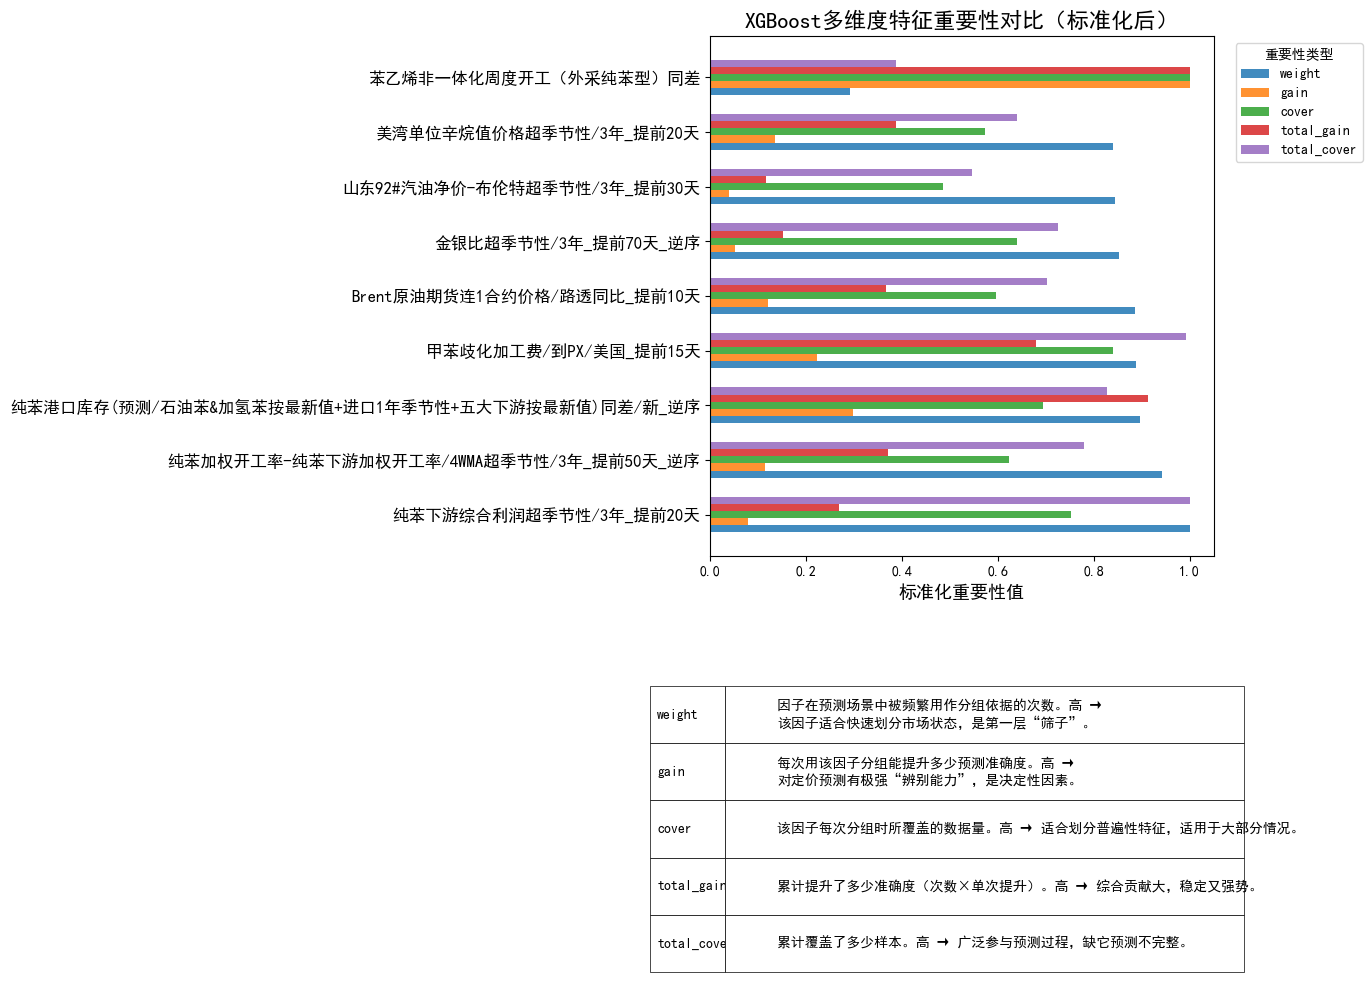

,weight,gain,cover,total_gain,total_cover
纯苯下游综合利润超季节性/3年_提前20天,1.000000,0.078340,0.751828,0.268614,1.000000
纯苯加权开工率-纯苯下游加权开工率/4WMA超季节性/3年_提前50天_逆序,0.941566,0.114808,0.622653,0.370653,0.779792
纯苯港口库存(预测/石油苯&加氢苯按最新值+进口1年季节性+五大下游按最新值)同差/新_逆序,0.895692,0.297335,0.694701,0.913167,0.827634
甲苯歧化加工费/到PX/美国_提前15天,0.887842,0.223485,0.840351,0.680346,0.992380
Brent原油期货连1合约价格/路透同比_提前10天,0.885749,0.120588,0.597097,0.366237,0.703457
金银比超季节性/3年_提前70天_逆序,0.852433,0.052214,0.640262,0.152614,0.725938
山东92#汽油净价-布伦特超季节性/3年_提前30天,0.844758,0.040270,0.486422,0.116645,0.546547
美湾单位辛烷值价格超季节性/3年_提前20天,0.839526,0.134325,0.573088,0.386667,0.639937
苯乙烯非一体化周度开工（外采纯苯型）同差,0.291645,1.000000,1.000000,1.000000,0.387914


In [19]:

#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)



In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/纯苯-Brent价差拟合残差-亚洲PX负荷_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
720,2025/11/25,NaN,-511.483612
719,2025/11/24,NaN,-476.299133
718,2025/11/21,NaN,-523.055481
717,2025/11/20,NaN,-572.675476
716,2025/11/19,NaN,-542.369324
...,...,...,...
4,2023/01/09,-439.2826,NaN
3,2023/01/06,-425.7196,NaN
2,2023/01/05,-35.2646,NaN
1,2023/01/04,107.0646,NaN


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/纯苯-Brent价差拟合残差-亚洲PX负荷_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,-796.431519
33,2025/10/31,-1182.263921,-278.448761
32,2025/09/30,-1008.144270,-686.578735
31,2025/08/31,-929.132367,-909.117554
30,2025/07/31,-732.456465,-731.460754
29,2025/06/30,-601.418900,-603.966431
28,2025/05/31,-981.280621,-976.442139
27,2025/04/30,-1065.679327,-1059.842285
26,2025/03/31,-646.969581,-647.810913
25,2025/02/28,-196.749426,-199.347321


In [22]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "纯苯-Brent价差拟合残差/亚洲PX负荷（自动）"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [23]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "纯苯-Brent价差拟合残差/亚洲PX负荷（自动）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [24]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'SC期货指数-Brent原油期货价格',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'SC期货指数-Brent原油期货价格\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'